# scTour pipeline

In [1]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_cell_indices(adata):
    # Get the indices of cells for the different populations
    cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
    unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))
    cebpa_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpa KO'].index.astype("int"))
    cebpe_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpe KO'].index.astype("int"))

    return cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells

In [4]:
adata = sc.read('/Users/paul/PycharmProjects/FLeCS/figure2/processed/adata_processed_with_paths_magic.h5ad')
adata.shape

/Users/paul/miniconda3/envs/sctour/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(7296, 4000)

In [5]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
adata = adata[cmp_cells + unsorted_cells].copy()

In [6]:
adata.shape

(4224, 4000)

In [7]:
adata.X = adata.layers["counts"]

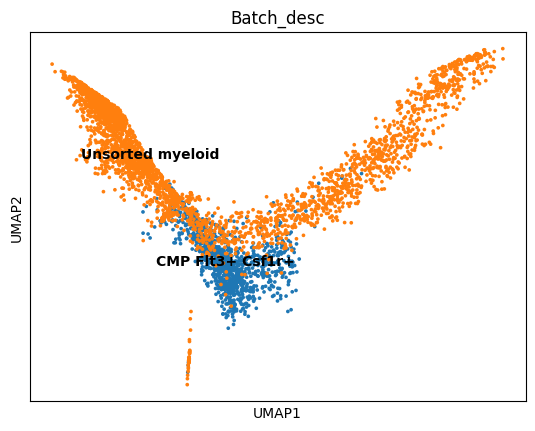

In [8]:
sc.pl.umap(adata, color=['Batch_desc'], legend_loc='on data')

## Model training

In [9]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [10]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=4000, subset=True)

In [11]:
tnode = sct.train.Trainer(adata, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5, n_latent=10)
tnode.train()

Running using CPU.
Epoch 400: 100%|██████████| 400/400 [16:40<00:00,  2.50s/epoch, train_loss=772, val_loss=778]    


## Infer cellular dynamics

### pseudotime

In [12]:
adata.obs['ptime'] = tnode.get_time()

In [13]:
adata.obs['ptime'] = sct.train.reverse_time(adata.obs['ptime'].values)

In [14]:
#zs represents the latent z from variational inference, and pred_zs represents the latent z from ODE solver
#mix_zs represents the weighted combination of the two, which is used for downstream analysis
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata.obsm['X_TNODE'] = mix_zs

In [15]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

## Save

In [16]:
adata.write_h5ad('/Users/paul/PycharmProjects/FLeCS/figure2/processed/adata_sctour_velo_10.h5ad')

## Visualization

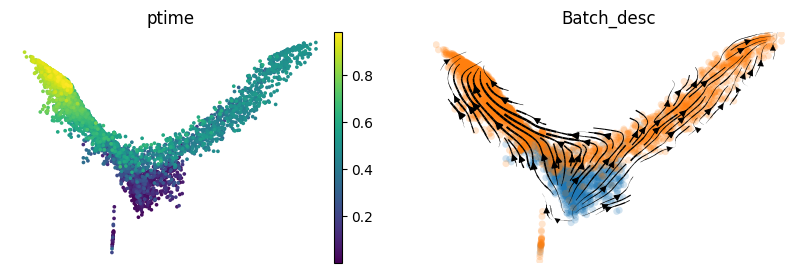

In [20]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
sc.pl.umap(adata, color='ptime', ax=axs[0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, reverse=True, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', 
                         color='Batch_desc', show=False, ax=axs[1], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()                                                                                            